### Edgar Moises Hernandez-Gonzalez
#### 29/04/20
#### Clasificacion binaria de imagenes motoras en EEG con CNN-1D + LSTM o CNN-1D + GRU
##### Caracteristicas = RWE-DWT
##### 5 ejecuciones independientes

##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (cohen_kappa_score, confusion_matrix,
                             roc_auc_score, roc_curve)
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv1D, MaxPool1D, Flatten, LSTM,
                          Dense, Dropout)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [ ]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE-DWT-Binaria/MI-EEG-ID-RWE-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE-DWT-Binaria/MI-EEG-ID-RWE-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE-DWT-Binaria/Etiquetas-ID-A01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE-DWT-Binaria/Etiquetas-ID-A01E.csv", header=None)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(144, 66)
(144, 66)
(144, 1)
(144, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 144
n_samples_test : 144


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 2


In [ ]:
#escalar los datos para que tengan media = 0 y desviacion estandar = 1
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
#convertir de 2D a 4D
x_train = x_train.reshape((n_samples_train, 1, 22, 3))
x_test = x_test.reshape((n_samples_test, 1, 22, 3))

print(x_train.shape)
print(x_test.shape)

(144, 1, 22, 3)
(144, 1, 22, 3)


In [ ]:
x_train = np.transpose(x_train, (0,1,3,2))
x_test = np.transpose(x_test, (0,1,3,2))

print(x_train.shape)
print(x_test.shape)

(144, 1, 3, 22)
(144, 1, 3, 22)


In [ ]:
#mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_RWE_ID_CNN1D_LSTM_01.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
def CNN_1D_LSTM():
  model = Sequential()
  model.add(TimeDistributed(Conv1D(32, 3, activation='relu', padding='same'),
                            input_shape=(None,3,22)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(64, dropout=0.5))
  model.add(Dense(16))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

Iteration: 1
loss:  0.637471874554952
accuracy:  0.6736111044883728
kappa:  0.3472222222222222
confusion matrix:
 [[50 22]
 [25 47]]
AUC 0.740354938271605


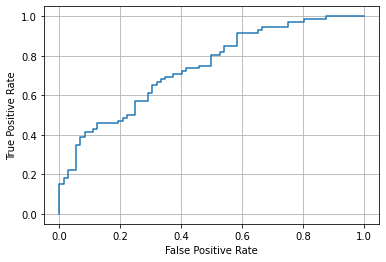

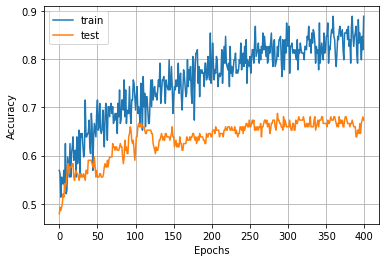

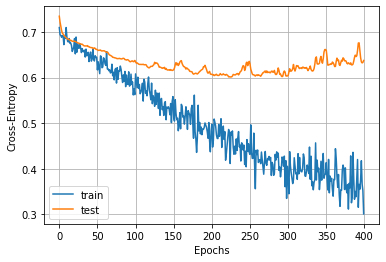

Iteration: 2
loss:  0.6051621238390604
accuracy:  0.7013888955116272
kappa:  0.4027777777777778
confusion matrix:
 [[56 16]
 [27 45]]
AUC 0.7654320987654321


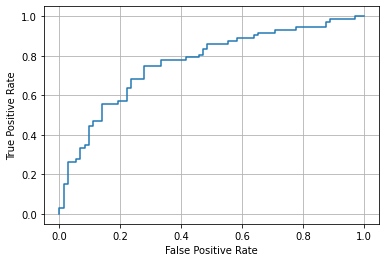

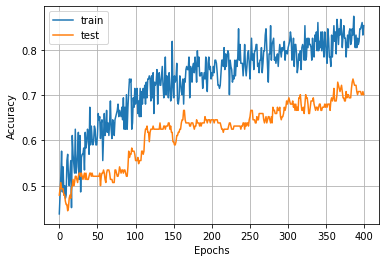

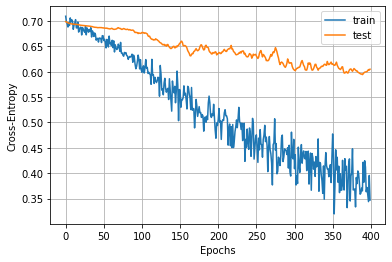


Resultados:
loss: [0.637471874554952, 0.6051621238390604]
accuracy: [0.6736111044883728, 0.7013888955116272]
kappa: [0.3472222222222222, 0.4027777777777778]


In [ ]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  model = CNN_1D_LSTM()

  history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
                      #callbacks=[mc])
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  fpr, tpr, thresholds = roc_curve(y_test, probabilidades)

  print("AUC", auc)
  plt.plot(fpr, tpr)
  plt.grid()
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 3, 32)       2144      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 96)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 44,434
Trainable params: 44,434
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6875
std: (+/- 0.0139)
Mean Kappa: 0.3750
std: (+/- 0.0278)
Max Accuracy: 0.7014
Max Kappa: 0.4028
